In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 15000
stocks = ['9064', '9061', '9265']

In [3]:
d_stocks = {}
d_cv_stocks = {}
d_test_stocks = {}
for s in stocks:
    d, d_cv, d_test = lob.load_prepared_data(
        s, data_dir='../queue_imbalance/data/prepared', cv=True, length=data_length)
    d.index = pd.to_datetime(d['Unnamed: 0'].values)
    d_cv.index = pd.to_datetime(d_cv['Unnamed: 0'].values)
    d_test.index = pd.to_datetime(d_test['Unnamed: 0'].values)
    d_stocks[s] = d
    d_cv_stocks[s] = d_cv
    d_test_stocks[s] = d_test

In [4]:
for s in stocks:
    print(s)
    print(min(d_stocks[s].index), max(d_stocks[s].index))
    print(min(d_cv_stocks[s].index), max(d_cv_stocks[s].index))
    print(min(d_test_stocks[s].index), max(d_test_stocks[s].index))

9064
2013-09-12 14:41:00 2013-10-23 10:38:00
2013-10-23 10:40:00 2013-11-05 13:32:00
2013-09-02 09:00:00 2013-09-12 14:40:00
9061
2013-09-13 10:36:00 2013-10-24 10:00:00
2013-10-24 10:01:00 2013-11-06 14:54:00
2013-09-02 09:00:00 2013-09-13 10:35:00
9265
2013-09-16 09:45:00 2013-10-29 11:42:00
2013-10-29 11:43:00 2013-11-12 12:36:00
2013-09-02 09:00:00 2013-09-16 09:44:00


## Data visualization

#### Density Queue imbalance vs mid price

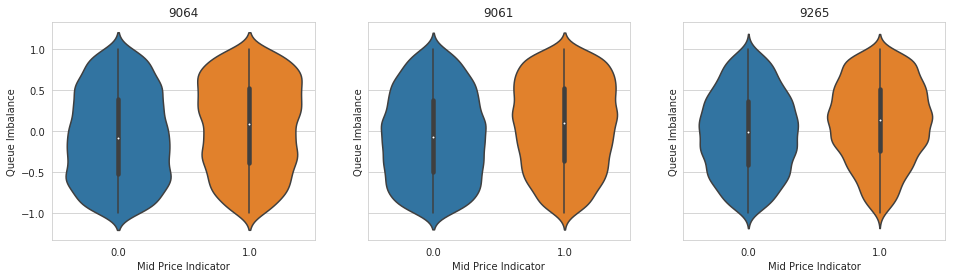

In [5]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(16, 4))
i = 0
plt.title('Violin Plots of Queue Imbalance vs Mid Price Indicator')
for k, d in d_stocks.items():
    sns.violinplot(y=d['queue_imbalance'], x=d['mid_price_indicator'], ax=ax[i])
    ax[i].set_title(k)
    ax[i].set_ylabel('Queue Imbalance')
    ax[i].set_xlabel('Mid Price Indicator')
    i += 1

plt.ylabel('Queue Imbalance')
plt.xlabel('Mid Price Indicator')
plt.savefig('violin_plot_imb_vs_ind.png')

Text(0.5, 1.0, 'Queue Imbalance vs Mid Price Indicator')

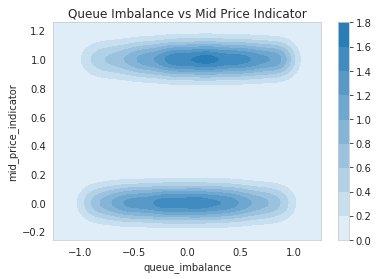

In [6]:
sns.kdeplot(d['queue_imbalance'], d['mid_price_indicator'], shade=True, cbar=True)
plt.title('Queue Imbalance vs Mid Price Indicator')

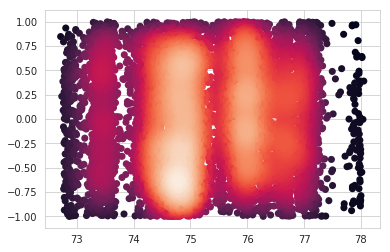

<Figure size 432x288 with 0 Axes>

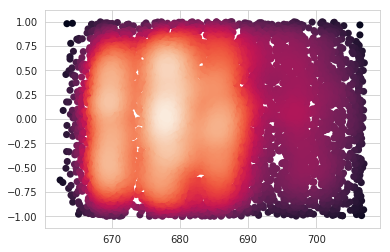

<Figure size 432x288 with 0 Axes>

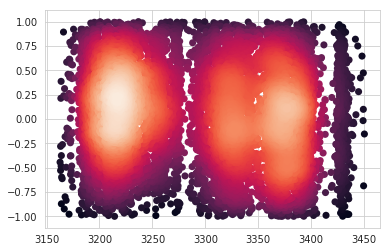

<Figure size 432x288 with 0 Axes>

In [7]:
lob.plot_density_imbalance_vs_mid(d_stocks[stocks[0]], 0, len(d_stocks[stocks[0]]))
lob.plot_density_imbalance_vs_mid(d_stocks[stocks[1]], 0, len(d_stocks[stocks[1]]))
lob.plot_density_imbalance_vs_mid(d_stocks[stocks[2]], 0, len(d_stocks[stocks[2]]))

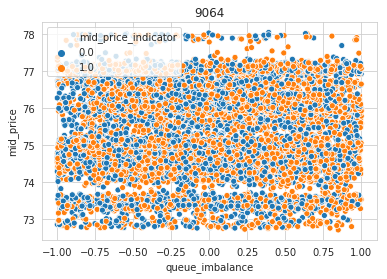

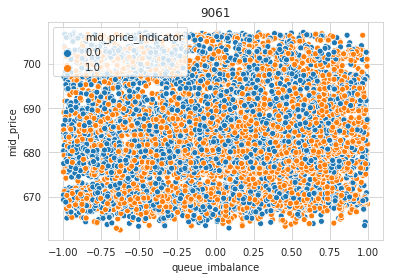

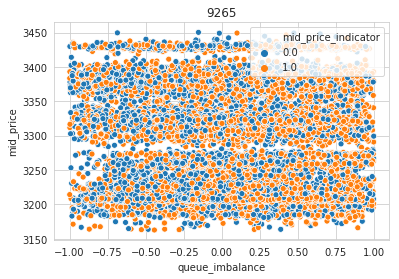

<Figure size 432x288 with 0 Axes>

In [8]:
for k, d in d_stocks.items():
    sns.scatterplot(d['queue_imbalance'], d['mid_price'], hue=d['mid_price_indicator'])
    plt.title(k)
    plt.figure()

#### Mid Price Visualization

9000
9000
9000


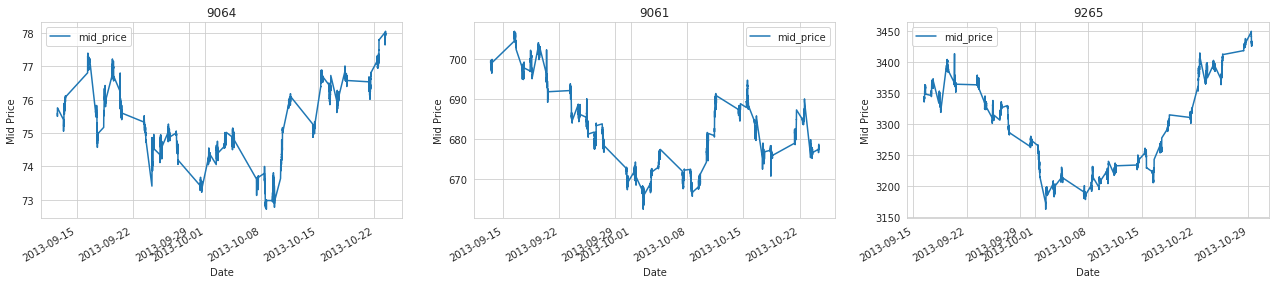

In [9]:
f, ax = plt.subplots(1, 3, figsize=(22, 4))
for i in range(len(stocks)):
    print(len(d_stocks[stocks[i]]))
    d_stocks[stocks[i]][['mid_price']].plot(label=stocks[i], ax=ax[i])
    ax[i].set_title(stocks[i])
    ax[i].set_ylabel('Mid Price')
    ax[i].set_xlabel('Date')
    ax[i].legend()

plt.legend()
plt.savefig('mid_price.png')

3000
3000
3000


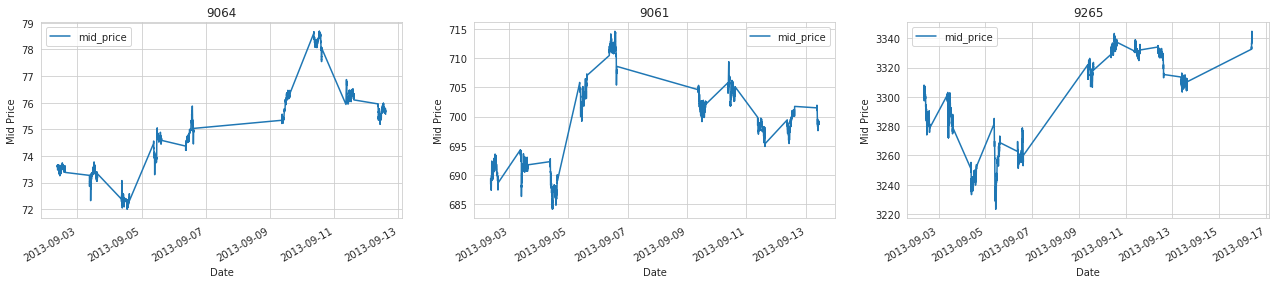

In [10]:
f, ax = plt.subplots(1, 3, figsize=(22, 4))
for i in range(len(stocks)):
    print(len(d_cv_stocks[stocks[i]]))
    d_test_stocks[stocks[i]][['mid_price']].plot(label=stocks[i], ax=ax[i])
    ax[i].set_title(stocks[i])
    ax[i].set_ylabel('Mid Price')
    ax[i].set_xlabel('Date')
    ax[i].legend()

plt.legend()
#plt.savefig('mid_price_validation_data.png')

## Logistic

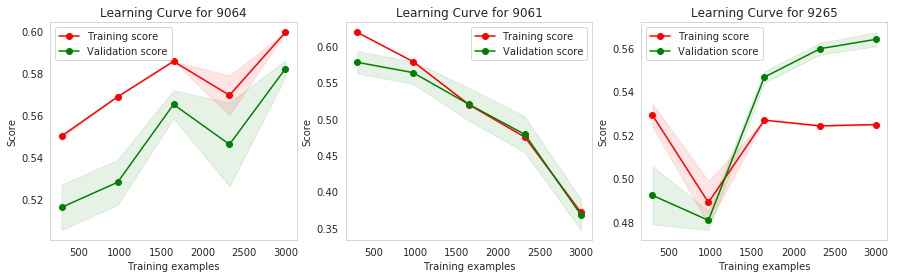

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit

f, ax = plt.subplots(1, 3, figsize=(15,4))
i = 0
for stock in stocks:
    log_clf = lob.logistic_regression(d_stocks[stock], 0, len(d_stocks[stock]))
    lob.plot_learning_curve(
        log_clf, d_stocks[stock]['queue_imbalance'].values.reshape(-1, 1),
        d_stocks[stock]['mid_price_indicator'], 
        cv=TimeSeriesSplit(n_splits=2), ax=ax[i], scoring='f1')
    ax[i].set_title('Learning Curve for {}'.format(stock))
    i += 1
plt.savefig('logistic_regression_learning_curves.png')

9000 3000 3000
9000 3000 3000
9000 3000 3000


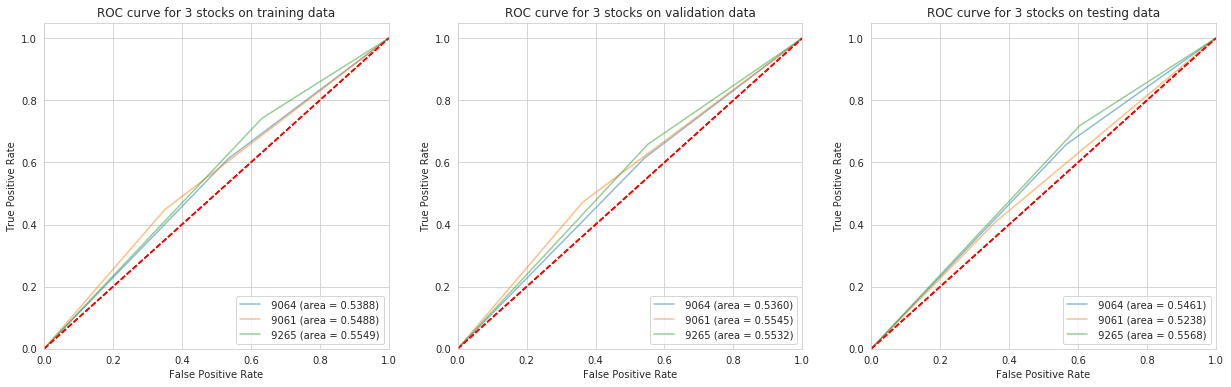

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))
for stock in stocks:
    log_clf = lob.logistic_regression(d_stocks[stock], 0, len(d_stocks[stock]))
    pred_train = log_clf.predict(d_stocks[stock]['queue_imbalance'].values.reshape(-1, 1))
    pred_cv = log_clf.predict(d_cv_stocks[stock]['queue_imbalance'].values.reshape(-1, 1))
    pred_test = log_clf.predict(d_test_stocks[stock]['queue_imbalance'].values.reshape(-1, 1))
    d_stocks[stock]['pred_log'] = pred_train
    d_cv_stocks[stock]['pred_log'] = pred_cv
    d_test_stocks[stock]['pred_log'] = pred_test
    print(len(d_stocks[stock]),len(d_cv_stocks[stock]), len(d_test_stocks[stock]) )
    lob.plot_roc(d_stocks[stock], log_clf, stock=stock, label='', alpha=0.5, linestyle='-', ax=ax1,
                 title='ROC curve for 3 stocks on training data')
    lob.plot_roc(d_cv_stocks[stock], log_clf, stock=stock, label='', alpha=0.5, linestyle='-', ax=ax2,
                 title='ROC curve for 3 stocks on validation data')
    lob.plot_roc(d_test_stocks[stock], log_clf, stock=stock, label='', alpha=0.5, linestyle='-', ax=ax3,
                 title='ROC curve for 3 stocks on testing data')
    plt.savefig('logistic_regression_results.png')

In [13]:
def get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock):
    scores = {'stock': stock}
    for func_name, func in functions_to_run.items():
        for df_name, df in dfs.items():
            pred = log_clf.predict(df['queue_imbalance'].values.reshape(-1, 1))
            scores['{}_{}'.format(func_name, df_name)] = func(df['mid_price_indicator'], pred)
    return scores
            
functions_to_run = {'precision': metrics.precision_score, 'accuracy': metrics.accuracy_score, 
                   'f1_score': metrics.f1_score, 'recall': metrics.recall_score}
scores = []
for stock in stocks:
    log_clf = lob.logistic_regression(d_stocks[stock], 0, len(d_stocks[stock]))
    dfs = {'train': d_stocks[stock], 'val': d_cv_stocks[stock], 'test': d_test_stocks[stock], }
    scores.append(get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock))
df_scores = pd.DataFrame(scores, index=stocks)

In [14]:
df_scores[['precision_train', 'precision_val', 'precision_test', 'recall_train', 'recall_val', 'recall_test']]


,precision_train,precision_val,precision_test,recall_train,recall_val,recall_test
9064,0.546473,0.518754,0.546493,0.612652,0.614911,0.658585
9061,0.552220,0.557706,0.533591,0.498433,0.515573,0.464070
9265,0.552756,0.549346,0.549396,0.690190,0.611516,0.666445


In [15]:
df_scores[['accuracy_train', 'accuracy_val', 'accuracy_test', 'f1_score_train', 'f1_score_val', 'f1_score_test']]

,accuracy_train,accuracy_val,accuracy_test,f1_score_train,f1_score_val,f1_score_test
9064,0.540556,0.534333,0.548333,0.577673,0.562754,0.597325
9061,0.550556,0.550667,0.532667,0.523950,0.535813,0.496408
9265,0.558444,0.551667,0.559333,0.613875,0.578766,0.602286


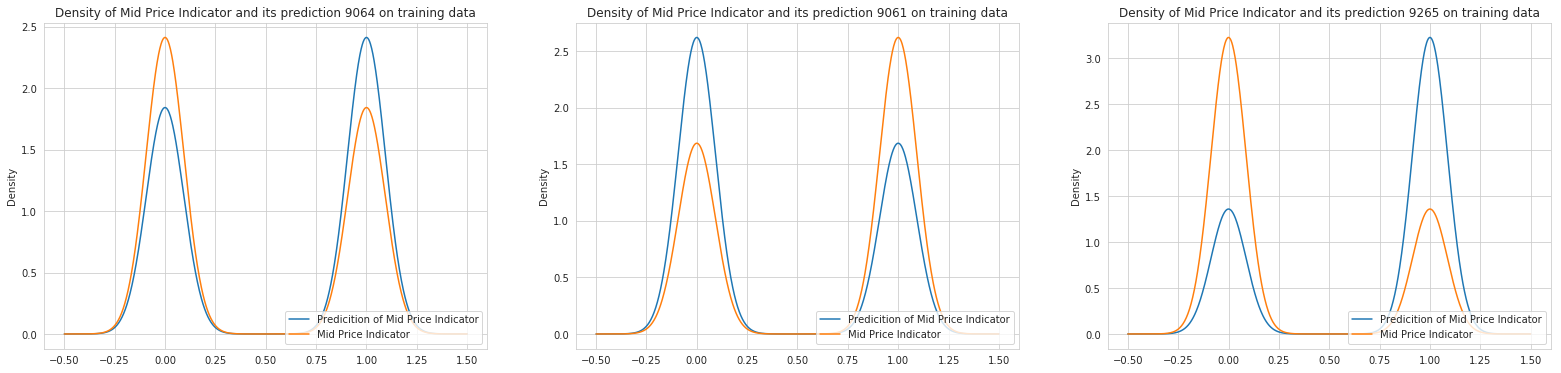

In [16]:
f, ax = plt.subplots(1, 3, figsize=(27,6))
for i in range(len(stocks)):
    stock = stocks[i]
    d_stocks[stock]['Predicition of Mid Price Indicator'] = d_stocks[stock]['pred_log']
    d_stocks[stock]['Mid Price Indicator'] = d_stocks[stock]['mid_price_indicator']
    d_stocks[stock][d_stocks[stock]['pred_log'] != d_stocks[stock][
        'mid_price_indicator']][['Predicition of Mid Price Indicator', 'Mid Price Indicator']].plot(
        kind='kde', ax=ax[i])
    ax[i].set_title('Density of Mid Price Indicator and its prediction {} on training data'.format(stock))
    ax[i].legend(loc='lower right')
plt.savefig('density_of_mid_price_and_prediction_training_data.png')

-0.13932079460864202 -0.13950738916256158 0.5406666666666666
0.18352059925093636 0.18316731042894896 0.5493333333333333
-0.22494245658087467 -0.2253005750130685 0.5592222222222222


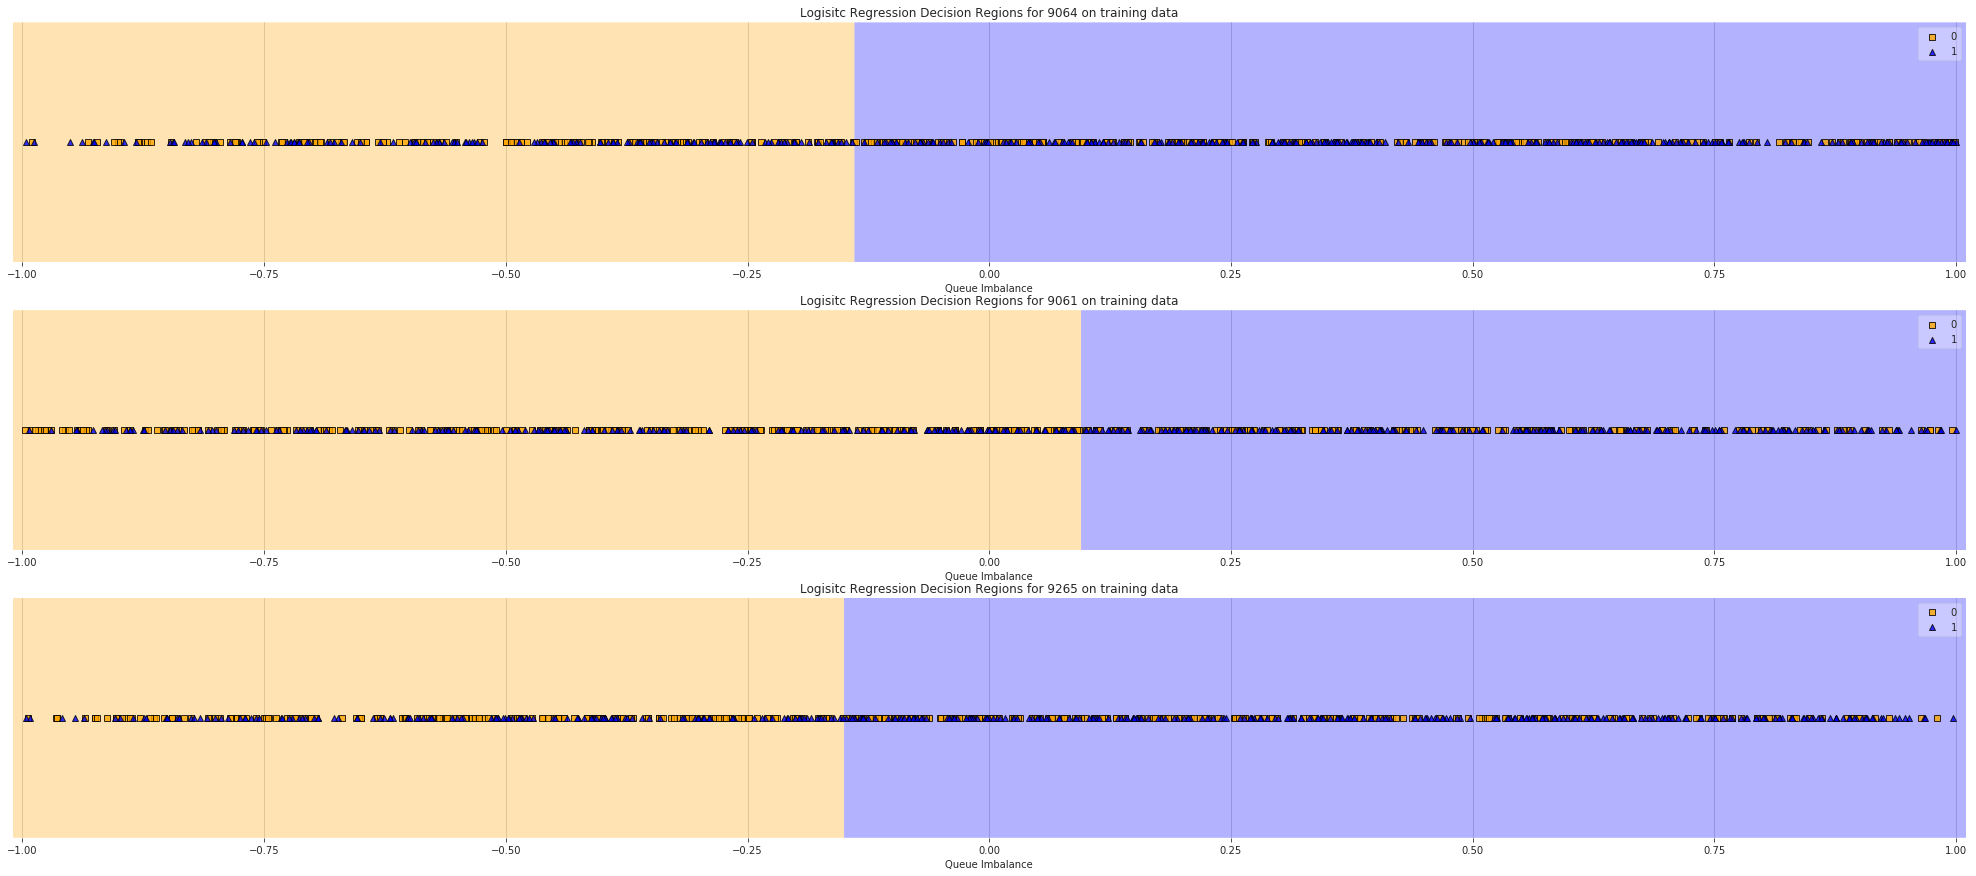

In [17]:
f, ax = plt.subplots(3, 1, figsize=(35, 15), sharex=True)
i = 0

for i in range(len(stocks)):
    stock = stocks[i]
    df = d_stocks[stock]
    X = df[['queue_imbalance']].values
    y = df['mid_price_indicator'].values.astype(np.integer)

    clf = lob.logistic_regression(df, 0, len(df))
    plot_decision_regions(X[0:900], y[0:900], clf=clf,ax=ax[i], colors=','.join(['orange', 'blue']))
    ax[i].set_xlabel('Queue Imbalance')
    ax[i].set_title('Logisitc Regression Decision Regions for {} on training data'.format(stock))
    ax[i].set_xlim(-1.01, 1.01)
    print(min(df[df['pred_log'] == 1]['queue_imbalance']), max(df[df['pred_log'] == 0]['queue_imbalance']),
        clf.score(X, y))


plt.savefig('logistic_regression_decision_region.png'.format(s))